<a href="https://colab.research.google.com/github/Jorbnc/MAIA-UL/blob/main/03_UL_microproyecto_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from skimage import io, color
from skimage.transform import rescale
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans

# Espacio de color CIELAB

El espacio de color CIELAB es un modelo cromático usado para describir todos los colores que puede percibir el ojo humano (`rojo`, `verde`, `azul` y `amarillo`) y tiene la intención de mimetizar la respuesta no lineal del sistema visual.

Este espacio de color utiliza tres dimensiones:
- Luminosidad `L*` (negro a blanco), con rango continuo `0:100`
- Eje verde-rojo `a*`, con rango continuo `-128:127`
- Eje azul-amarillo `a*`, con rango continuo `-128:127`
  
Entonces el cálculo de distancias euclidianas entre colores es válido en este espacio.

La función `color.rgb2lab` de la librería `skimage` permite transformar de un espacio de color RGB a uno CIELAB.
- El argumento `illuminant` puede ser “A”, “B”, “C”, “D50”, “D55”, “D65”, “D75”, “E”. `'D65'` es el valor por defecto.
- `color.rgb2lab` realiza la conversión entre RGB y CIELAB de forma segura, manejando los rangos apropiadamente

---
- https://en.wikipedia.org/wiki/CIELAB_color_space#Perceptual_differences
- https://es.wikipedia.org/wiki/Espacio_de_color_Lab
- https://scikit-image.org/docs/stable/api/skimage.color.html#skimage.color.rgb2lab
- https://stackoverflow.com/questions/52459146/what-should-be-the-input-to-skimage-color-rgb2lab

# Test (transformación RGB a CIELAB)

In [ ]:
rgb_test = np.array([100, 50, 125]).astype(np.uint8)
color.rgb2lab(rgb_test)
# Coincide con los resulados de http://colormine.org/convert/rgb-to-lab

array([ 30.57176673,  36.06177058, -33.60828633])

# Pipeline
## Preprocesamiento

In [ ]:
# Downsampling
def reescalar_img(img: np.ndarray, factor: float):
    img_rescaled = rescale(
        img,
        scale=factor,
        channel_axis=2, #especificar cuál es el canal de colores
        anti_aliasing=True, #suavizar durante el escalado
        preserve_range=True #mantener el rango de colores original
    )
    return img_rescaled.astype(img.dtype)

In [ ]:
# Cargar img reescalada en ambos espacios de color: RGB y LAB
def cargar_img_RGB_LAB_downsample(imgpath: str, factor: float = 0.25):
    rgb = io.imread(imgpath)
    rgb = reescalar_img(rgb, factor)
    lab = color.rgb2lab(rgb)
    return rgb, lab

In [ ]:
# Obtener data tabular: pixeles como filas y CIELAB como columnas
def img_to_tabular(img: np.ndarray):
    return img.reshape(-1, img.shape[-1])

## Clustering
Considerar esta métrica https://scikit-image.org/docs/stable/api/skimage.color.html#skimage.color.deltaE_cie76

In [ ]:
# Selección de Kmeans con base en silhouette_score
def KMeans_silhouette(X: np.ndarray, Kmin: int = 5, Kmax: int = 7):

    modelos = np.array([])
    silhouette_scores = np.array([])
    for k in range(Kmin, Kmax+1):
        modelo = KMeans(n_clusters=k, max_iter=300, n_init=10)
        modelo.fit(X)
        modelos = np.append(modelos, modelo)
        silhouette_scores = np.append(silhouette_scores, silhouette_score(X, modelo.labels_))

    [print("K=", i+5, " --> Silhouette Score:", score) for (i,score) in enumerate(silhouette_scores)]

    mejor_modelo = modelos[silhouette_scores.argmax()]
    mejor_k = len(mejor_modelo.cluster_centers_)
    centroids_RGB_img = color.lab2rgb(mejor_modelo.cluster_centers_).reshape((1,mejor_k,3))

    return centroids_RGB_img

## Paleta de colores + PCA + t-SNE

In [ ]:
def generar_paleta(imgpath: str, factor:float = 0.05):
    rgb_1, lab_1 = cargar_img_RGB_LAB_downsample(imgpath, factor=factor)
    lab_1_tabular = img_to_tabular(lab_1)
    paleta = KMeans_silhouette(lab_1_tabular)

    # Imagen reescalada + Paleta
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(rgb_1)
    ax[1].imshow(paleta)

    # PCA
    #...

    # t-SNE
    #...

K= 5  --> Silhouette Score: 0.5506775563394839
K= 6  --> Silhouette Score: 0.5735627153401281
K= 7  --> Silhouette Score: 0.5604322619718197
CPU times: user 57 s, sys: 15.7 s, total: 1min 12s
Wall time: 9.49 s


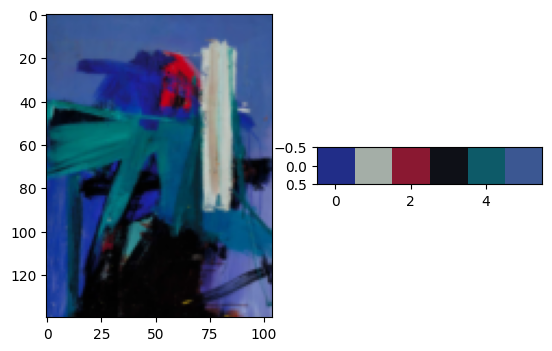

In [ ]:
%time generar_paleta("img/franz-kline_blueberry-eyes-1960.jpg", factor=0.075)

K= 5  --> Silhouette Score: 0.6224437545331639
K= 6  --> Silhouette Score: 0.6325776088845833
K= 7  --> Silhouette Score: 0.5742476182067955
CPU times: user 1min 6s, sys: 27.8 s, total: 1min 33s
Wall time: 12.7 s


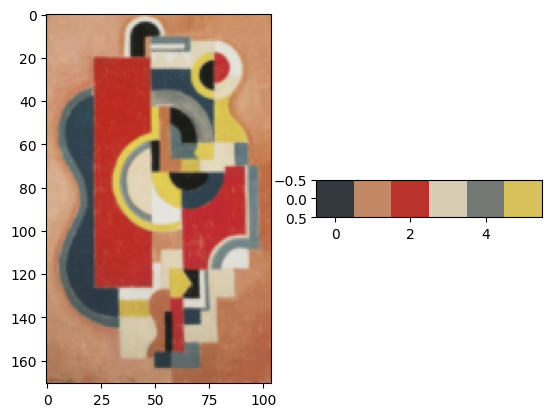

In [ ]:
%time generar_paleta("img/adolf-fleischmann_hommage-delaunay-et-gleizes-1938.jpg", factor=0.075)

K= 5  --> Silhouette Score: 0.3216125356863402
K= 6  --> Silhouette Score: 0.30569300163383356
K= 7  --> Silhouette Score: 0.31202208458488595
CPU times: user 1min 28s, sys: 44 s, total: 2min 12s
Wall time: 19.6 s


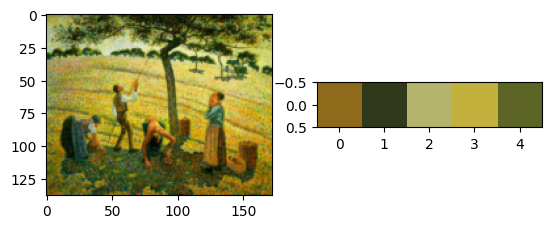

In [ ]:
%time generar_paleta("img/camille-pissarro_apple-picking-at-eragny-sur-epte-1888.jpg", factor=0.10)

K= 5  --> Silhouette Score: 0.3982865062563995
K= 6  --> Silhouette Score: 0.4076643839985289
K= 7  --> Silhouette Score: 0.38478111624561046
CPU times: user 1min 29s, sys: 41.4 s, total: 2min 11s
Wall time: 23 s


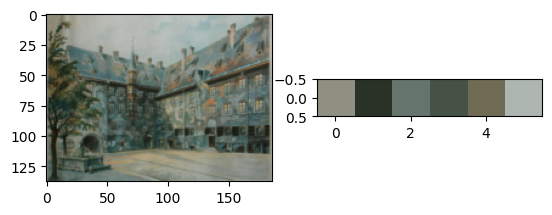

In [ ]:
%time generar_paleta("img/adolf-hitler_the-courtyard-of-the-old-residency-in-munich-1913.jpg", factor=0.10)

# Referencias